#### Autoencoder Denoising

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Explore dataset

In [56]:
data = pd.read_csv('./mnist_dataset.csv')
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# Select the fifth row from the DataFrame.
image = data.iloc[3]

# Convert the selected data to a NumPy array and change its data type to 'float32'.
# (784) -> (28x28)
image = np.array(image).astype('float32') 

# Reshape the array into a 28x28 2D array. 
image = np.reshape(image, (28, 28))

# Normalize the pixel values of the image by dividing each by 255.
# This scales the pixel values to a range of 0 to 1.
image = image / 255

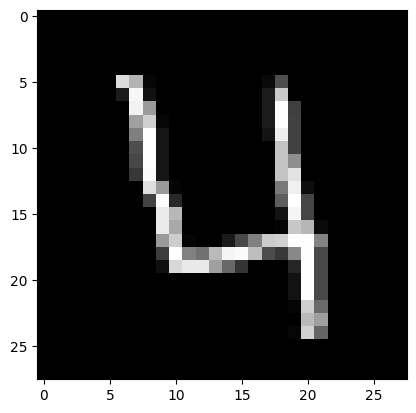

In [58]:
plt.imshow(image,cmap='gray')

In [59]:
rng = np.random.default_rng(0)

# Add Gaussian noise to the image and scale it down by a factor of 0.2.
noisy_img = image + 0.2 * rng.standard_normal(image.shape)

# Ensure all pixel values are within the 0 to 1 range.
noisy_img = np.clip(noisy_img, 0, 1)


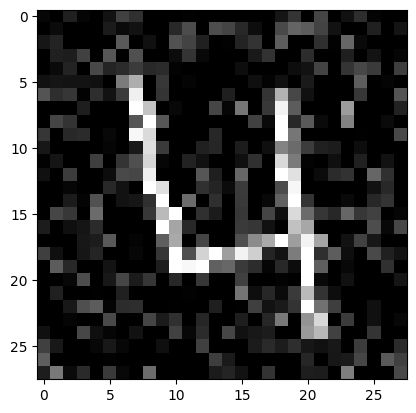

In [60]:
plt.imshow(noisy_img, cmap="gray")

#### Data Preparation

In [61]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

In [62]:
class mnist_ae_dataset(Dataset):
    
    def __init__(self,csv_file, noise_factor = 0.2, transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img,(28,28,1)) / 255
        
        rng = np.random.default_rng(0)
        noisy_img = img + self.noise_factor * rng.standard_normal(img.shape)
        noisy_img = np.clip(noisy_img,0,1)
        
        sample = (noisy_img,img)
        
        # Apply any additional transformations if provided.
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [63]:
trainset = mnist_ae_dataset('mnist_dataset.csv',transform=ToTensorForAE())

In [64]:
print(f"Size of trainset: {len(trainset)}")

Size of trainset: 42000


In [65]:
noisy_img, org_img = trainset[18]

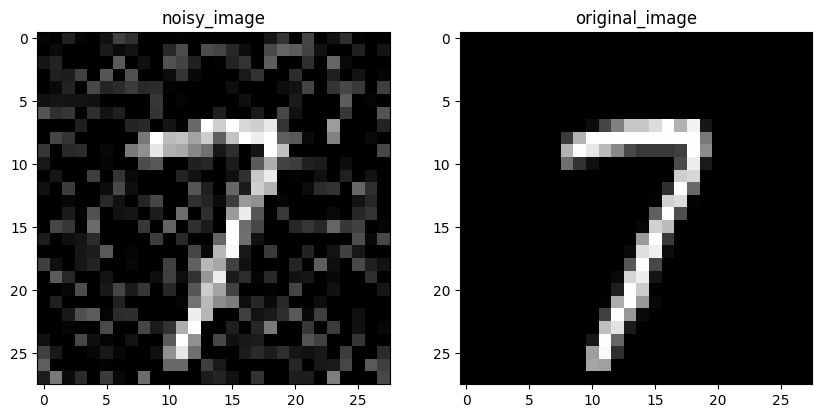

In [66]:
show_image(noisy_img, org_img)

#### Load Dataset into batches

In [67]:
from torch.utils.data import DataLoader

In [68]:
trainloader = DataLoader(trainset, batch_size= 16, shuffle= True)

In [ ]:
dataiter = iter(trainloader)
noisy_img, org_img = next(dataiter)

print(f"Shape of loading one batch : {noisy_img.shape}")
print(f"Total no. of batches : {len(trainloader)}")
print(f"Total no of examples : {len(trainloader.dataset)}")

#### Create AutoEncoder Model

In [70]:
from torch import nn
from torchsummary import summary



In [71]:
def encoder():
    enc = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    return enc

In [72]:
def decoder():
    dec = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(2,2), stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(2,2), stride=2),
        nn.Sigmoid()
    )
    return dec

In [ ]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        self.encoder = encoder()
        self.decoder = decoder()
        
    def forward(self,inp_imgs):
        
        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)
        
        return decoder_out
    
model = AutoEncoder()
model

In [74]:
#summary(model, input_size= (1,28,28))
summary(model.to('cuda'), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
   ConvTranspose2d-7           [-1, 32, 14, 14]           8,224
              ReLU-8           [-1, 32, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]             129
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 27,169
Trainable params: 27,169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 0.10
Estimated Tot

#### Train AutoEncoder Model

In [75]:
import torch.nn.functional as F
from tqdm import tqdm

criterion = nn.MSELoss()
epochs = 50  
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for i in range(epochs):
    train_loss = 0.0

    model.train()
    for batch in tqdm(trainloader):
        
        noisy_img, org_img = batch
        noisy_img, org_img = noisy_img.to(device), org_img.to(device)  # Move to the GPU
        
        noisy_img = F.interpolate(noisy_img, size=org_img.shape[2:], mode='bilinear', align_corners=False)
        
        denoised_img = model(noisy_img)
        
        org_img = F.interpolate(org_img, size=denoised_img.shape[2:], mode='bilinear', align_corners=False)
        
        loss = criterion(denoised_img, org_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(trainloader)
    print(f"Epoch: {i+1}, Average Train Loss: {avg_train_loss:.4f}")

#### Plot Results

Dimensions of denoised_img: torch.Size([1, 1, 28, 28])
Dimensions of denoised_img after squeeze: torch.Size([1, 28, 28])


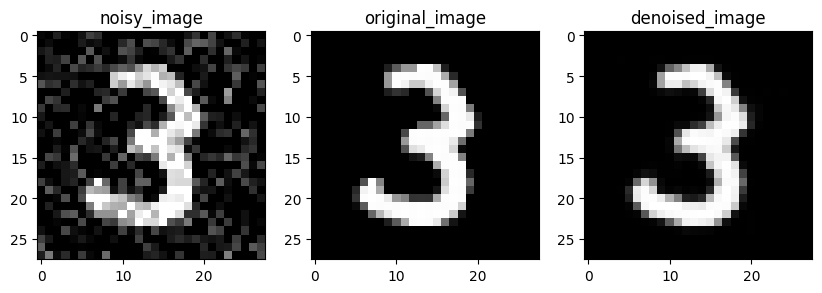

In [81]:
model.eval()

with torch.no_grad():
    
    dataiter = iter(trainloader)
    sample = next(dataiter)
    noisy_img, org_img = sample
    index = 2
    noisy_img = noisy_img.to(device)
    denoised_img = model(noisy_img[index].unsqueeze(0))
    
    print("Dimensions of denoised_img:", denoised_img.shape)
    
    if denoised_img.dim() == 4:  
        denoised_img = denoised_img.squeeze(0)  

    print("Dimensions of denoised_img after squeeze:", denoised_img.shape)
    
    show_image(noisy_img[index].cpu(), org_img[index].cpu(), denoised_img.cpu())